# define the state q by x, y, vx, vy
real transformation:
$ q_t = A_tq_{t-1} + B_ta_{t-1} $

In [2]:
%reload_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
from utils import plot_covariance_ellipse, plot_throwing

In [3]:


delta_t = 0.5
A = np.array([
    [1, 0, delta_t, 0],
    [0, 1, 0, delta_t],
    [0, 0, 1, 0],
    (0, 0, 0, 1)
], dtype=float)

B = np.array([
    [0, 0, 0],
    [0, 0.5*delta_t*delta_t, 0],
    [0, 0, 0],
    [0, delta_t, 0]
], dtype=float)

g = 10

action = np.array([0, -g, 0]).reshape((3,1))

# Simulate Observation, Adding normal distributed noise


In [4]:
def random_cov(dim, scale=100):
    L = np.tril(np.random.rand(dim, dim))*scale
    cov = L@L.T
    return cov

def build_cov(var:list[float]):
    dim = len(var)
    cov = np.eye(dim)
    np.fill_diagonal(cov, var)
    return cov

cov = build_cov([0.1,0.1])
print(cov)

rand_cov = random_cov(4)
print(rand_cov)

[[0.1 0. ]
 [0.  0.1]]
[[  103.41536791   405.05102062   133.38745209   308.8976403 ]
 [  405.05102062  3376.46614122  4565.68353145  2192.7028825 ]
 [  133.38745209  4565.68353145 10460.39494477  5218.97933838]
 [  308.8976403   2192.7028825   5218.97933838  7372.17869891]]


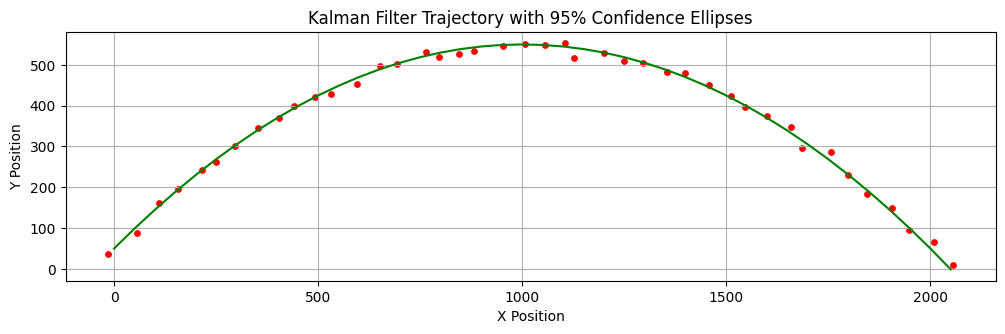

In [5]:
C = np.array([
    [1, 0, 0, 0],
    [0, 1, 0, 0]]
)
R = random_cov(2, 20)


def simulate_observe(q): 
    return C@q + np.random.multivariate_normal([0,0], R).reshape((2,1))

q0 = np.array([0, 50, 100, 100], dtype=float).reshape((4,1))
q_list = [q0]
o_list = [simulate_observe(q0)]
for t in range(1, int(30*1/delta_t), 1):
    q0 = A @ q0 + B @ action
    q_list.append(q0)
    o = simulate_observe(q0)
    # print(o)
    o_list.append(o)
    if q0[1] < 0:
        break
plot_throwing(np.array(q_list), np.array(o_list))

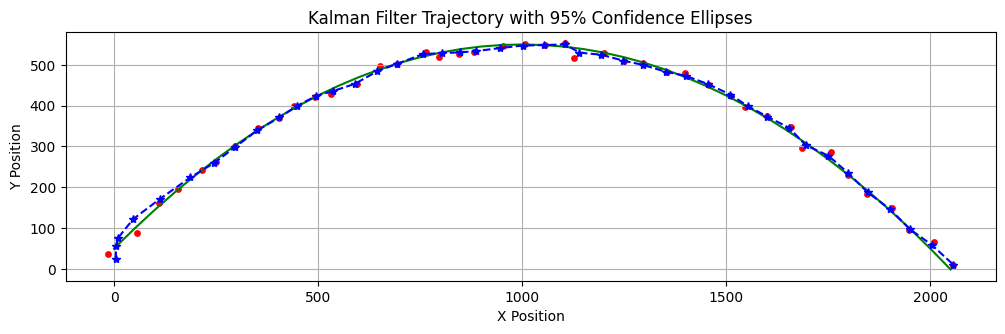

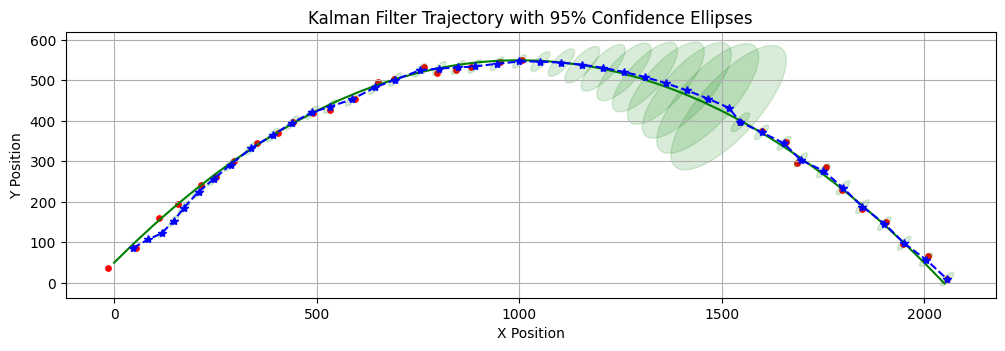

In [6]:
class KalmanFilter:
    def __init__(self):
        self.mu = np.random.random((4,1))*100
        self.sigma = np.eye(4, dtype=float)

        self.action = action # constant for ball throwing
        # self.Q = build_cov([1000, 1000, 2000, 2000]) # constant for ball throwing
        self.Q = random_cov(4,scale=5)
        self.R = R
        self.C = C

        self.q_preds = [self.mu]
        self.sgm_preds = [self.sigma]
    
    def update(self, observe=None):
        # o = np.array(observe).reshape((2,1))
        # prediction
        mu_ = A@self.mu + B@action
        sigma_ = A@self.sigma@A.T + self.Q
        if observe is None:
            self.mu = mu_
            self.sigma = sigma_
        else:
            # update
            # K = sigma_@self.C.T@np.linalg.inv(self.C@sigma_@self.C.T + self.R)
            K = np.linalg.solve((self.C@sigma_@self.C.T + self.R).T, (sigma_@self.C.T).T ).T
            self.mu = mu_ + K@(observe - self.C@mu_)
            self.sigma = (np.eye(4) - K@self.C)@sigma_

        self.q_preds.append(self.mu)
        self.sgm_preds.append(self.sigma)

kf = KalmanFilter()

for o in o_list:
    kf.update(o)

plot_throwing(np.array(q_list), np.array(o_list), np.array(kf.q_preds))

# o_list[0:5] = [np.ones(shape=(2,1),dtype=float)*100]*5
o_num = len(o_list)
o_list[o_num//2:o_num//2+10] = [None]*10 

kf1 = KalmanFilter()
for o in o_list:
    kf1.update(o)
plot_throwing(np.array(q_list), np.array([o for o in o_list if o is not None]), np.array(kf1.q_preds), np.array(kf1.sgm_preds))
